In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import scipy.io as sio

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(1)

import seaborn as sns
import pandas as pd
from astropy.io import fits

sns.set(font_scale=2)
sns.set_style("whitegrid")

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# Step 1: import catalogs and galaxy IDs [and flags]

In [2]:
# SEDs in magnitudes
candels_cat_small = np.loadtxt('catalogs/CANDELS_GDSS_workshop.dat')

# subtracting 1 from the ID for python indexing
cat_small_ids = candels_cat_small[0:,0] - 1
cat_small_z = candels_cat_small[0:,1]

print(str(cat_small_z.shape[0])+' galaxies in the small catalog.')

#------------------------------------------------------------------------------

candels_cat_z1 = np.loadtxt('catalogs/CANDELS_GDSS_workshop_z1.dat')

# subtracting 1 from the ID for python indexing
cat_z1_ids = candels_cat_z1[0:,0] - 1
cat_z1_z = candels_cat_z1[0:,1]
print(str(cat_z1_z.shape[0])+' galaxies in the z~1 catalog.')

#------------------------------------------------------------------------------

candels_cat_z3 = np.loadtxt('catalogs/CANDELS_GDSS_workshop_z3.dat')

# subtracting 1 from the ID for python indexing
cat_z3_ids = candels_cat_z3[0:,0] - 1
cat_z3_z = candels_cat_z3[0:,1]

print(str(cat_z3_z.shape[0])+' galaxies in the z~3 catalog.')

z1flag_cat = np.genfromtxt('catalogs/flags_z1.dat')
z1flag_ids = z1flag_cat[0:,0]

z1_mask = np.zeros_like(cat_z1_ids)
for i in range(len(z1flag_ids)):
    z1_mask[cat_z1_ids == z1flag_ids[i]-1 ] = 1
    
z3flag_cat = np.genfromtxt('catalogs/flags_z3.dat')
z3flag_ids = z3flag_cat[0:,0]

z3_mask = np.zeros_like(cat_z3_ids)
for i in range(len(z3flag_ids)):
    z3_mask[cat_z3_ids == z3flag_ids[i]-1 ] = 1

23 galaxies in the small catalog.
371 galaxies in the z~1 catalog.
161 galaxies in the z~3 catalog.


# Step 2: import outputs of all the SED fitting codes.

In [3]:
%run import_scripts/import_p16_fits.py
%run import_scripts/import_dense_basis_fits.py
%run import_scripts/import_fitsed_fits.py
%run import_scripts/import_nima_lephare_fits.py
%run import_scripts/import_marianna_zphot_fits.py
%run import_scripts/import_prospector_fits.py
%run import_scripts/import_bagpipes_fits.py
%run import_scripts/import_cigale_fits.py
%run import_scripts/import_interrogator_fits.py
%run import_scripts/import_speedyMC_fits.py
%run import_scripts/import_eazy_fits.py
%run import_scripts/import_magphys_fits.py
%run import_scripts/import_beagle_fits.py
%run import_scripts/import_sed3fit_fits.py

imported pacifici+16 fits.
imported dense basis fits.
imported FITSED (salmon+15?) fits.
imported Nima's LePhare fits.
imported Marianna's (zPhot) fits.
imported Prospector fits.
imported bagpipes fits.
imported cigale fits.
imported interrogator fits.
imported SpeedyMC fits.
imported eazy fits.
imported magphys fits.
imported beagle fits.
imported SED3fit fits.


# Step 3: Take everyone's data and put it in a dataframe, then start the visualization and analysis.

## define dataframes below for Mass, SFR and dust at z~1. Change the dictionary labels here to change the x-tick labels in the violin- and box-plots.

In [4]:
# dataframes for Mass, SFR and dust at z~1

warnings.filterwarnings('ignore')

brett_mass_z3_masked = brett_mass_z3
brett_mass_z3_masked[brett_mass_z3_masked < 0] = np.nan

nima_mass_z3_masked = nima_mass_z3
nima_mass_z3_masked[nima_mass_z3_masked < 0] = np.nan

# Missing codes: BEAGLE, EAZY, Cigale, Prospector any others ???

# 'MAGPHYS [no AGN]':magphys_mass_z3, 
# 'MAGPHYS [w/AGN]':magphys_mass_z3_wagn, 

z3_cat_mass_dict = {'zPhot':marianna_mass_z3, 
                    'LePhare':nima_mass_z3_masked, 
                    'FITSED':brett_mass_z3_masked, 
                    'MAGPHYS':magphys_mass_z3, 
                    #'EAZY':np.zeros_like(marianna_mass_z3)*np.nan, 
                    'SpeedyMC [linexp]':speedy_mass_z3,
                    'Cigale':cigale_z3_noagn_mass, # why the factor of 1000 increase? - fixed w/ new fits.
                    #'Cigale':cigale_z3_wagn_mass-3, # why the factor of 1000 increase?
                    'Dense Basis': DB_mass_z3.ravel(), 
                    'Pacifici+16': cami_mass_z3.ravel(), 
                    'Prospector': prospector_mass_z3,
                    'Bagpipes': bagpipes_mass_z3, 
                    'Beagle': beagle_mass_z3,
                    'SED3FIT':sed3fit_mass_z3,
                    'Interrogator [BPASS]':interrogator_mass_z3_bpass.ravel(), 
                    'Interrogator [Pegase]':interrogator_mass_z3_pegase.ravel()}
z3_cat_mass = pd.DataFrame(data=z3_cat_mass_dict)

z3_cat_mass[z3_cat_mass < 7] = np.nan

# 'MAGPHYS [no AGN]':magphys_sfr_z3, 
# 'MAGPHYS [w/AGN]':magphys_sfr_z3_wagn, 

z3_cat_sfr_dict = {'zPhot':marianna_sfr_z3, 
                    'LePhare':nima_sfr_z3, 
                    'FITSED':brett_sfr_z3, 
                    'MAGPHYS':magphys_sfr_z3, 
                    #'EAZY':np.zeros_like(marianna_mass_z3)*np.nan, 
                    'SpeedyMC [linexp]':speedy_sfr_z3,
                    'Cigale':cigale_z3_noagn_sfr, # why the factor of 1000 increase? - fixed w/ new fits
                    #'Cigale [w/AGN]':cigale_z3_wagn_sfr-3, # why the factor of 1000 increase?
                    'Dense Basis': DB_sfr_z3.ravel(), 
                    'Pacifici+16': cami_sfr_z3.ravel(), 
                    'Prospector': prospector_sfr_z3,
                    'Bagpipes': bagpipes_sfr_z3, 
                    'Beagle': beagle_sfr_z3,
                    'SED3FIT':sed3fit_sfr_z3,
                    'Interrogator [BPASS]':interrogator_sfr_z3_bpass, 
                    'Interrogator [Pegase]':interrogator_sfr_z3_pegase}
z3_cat_sfr = pd.DataFrame(data=z3_cat_sfr_dict)

z3_cat_sfr[z3_cat_sfr < -3] = -3 # fixes the stretching that a lot of the SFR distributions show due to exrtemely low SFRs

interrogator_Av_z3_bpass[interrogator_Av_z3_bpass < 0] = np.nan
interrogator_Av_z3_pegase[interrogator_Av_z3_pegase < 0] = np.nan

# 'MAGPHYS [no AGN]':magphys_Av_z3, 
# 'MAGPHYS [w/AGN]':magphys_Av_z3_wagn, 

z3_cat_Av_dict = {'zPhot':marianna_Av_z3, 
                    'LePhare':nima_Av_z3, 
                    'FITSED':brett_Av_z3, 
                    'MAGPHYS':magphys_Av_z3, 
                    #'EAZY':np.zeros_like(marianna_mass_z3)*np.nan, 
                    'SpeedyMC [linexp]':speedy_Av_z3,
                    #'Cigale':np.zeros_like(marianna_mass_z3)*np.nan, 
                    'Cigale':cigale_z3_noagn_Av,
                    #'Cigale [w/AGN]':cigale_z3_wagn_Av,
                    'Dense Basis': DB_Av_z3.ravel(), 
                    'Pacifici+16': cami_Av_z3.ravel(), 
                    'Prospector': prospector_Av_z3,
                    'Bagpipes': bagpipes_Av_z3, 
                    'Beagle': beagle_Av_z3,
                    'SED3FIT':sed3fit_av_z3,
                    'Interrogator [BPASS]':interrogator_Av_z3_bpass, 
                    'Interrogator [Pegase]':interrogator_Av_z3_pegase}
z3_cat_Av = pd.DataFrame(data=z3_cat_Av_dict)

print(z3_cat_mass.shape)
print(z3_cat_sfr.shape)
print(z3_cat_Av.shape)

(161, 14)
(161, 14)
(161, 14)


# make (and save) plots: 

# z=3 | M$_*$, SFR, A$_V$ distribution [violin plots]

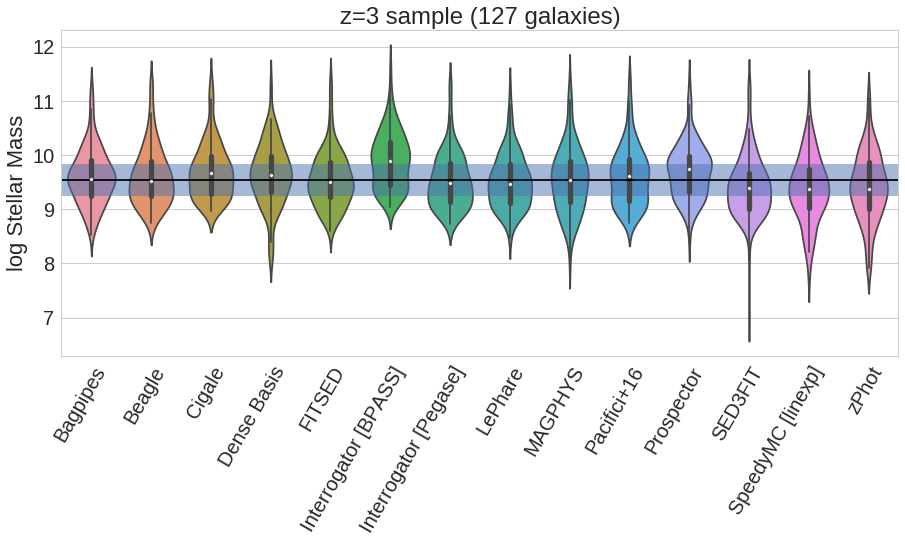

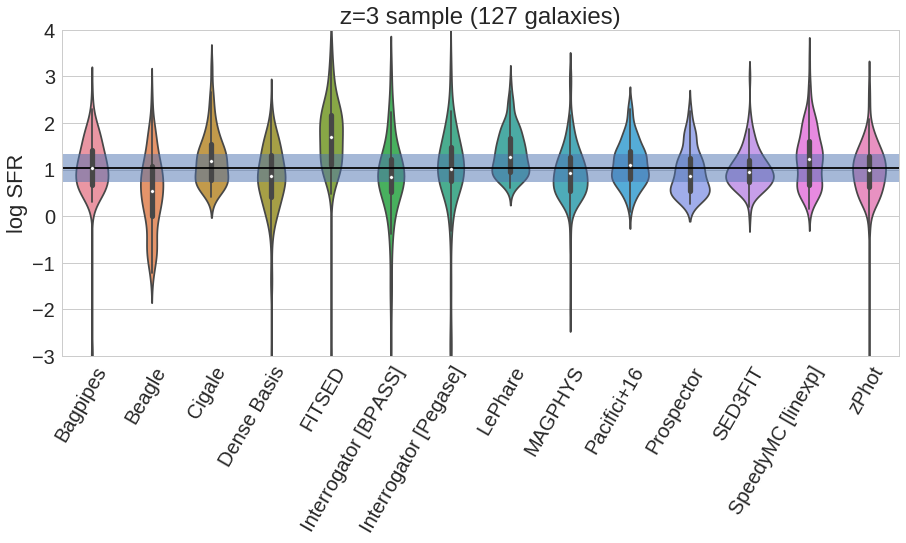

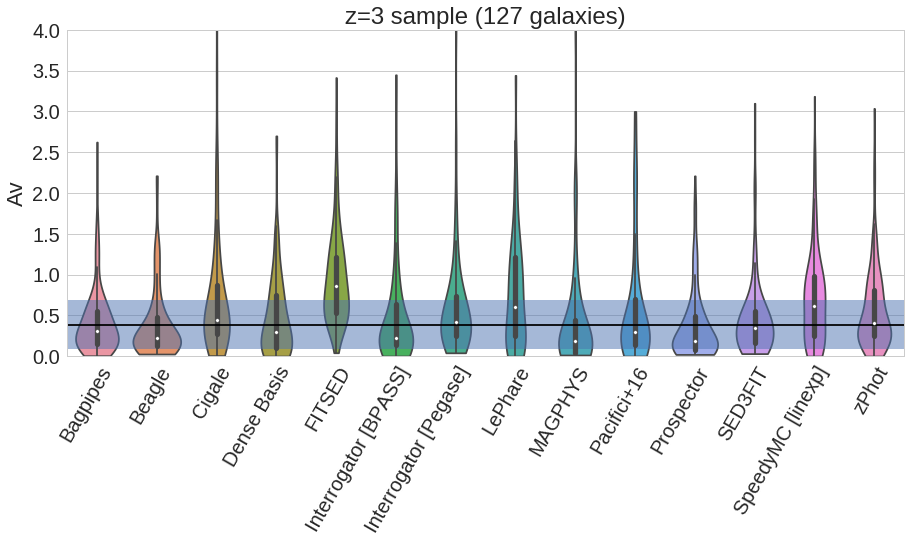

In [5]:


plt.figure(figsize=(15,6))
ax = sns.violinplot(data=z3_cat_mass[z3_mask == 0], orient='v',zorder=10)


median_mass_val = np.nanmedian(z3_cat_mass[z3_mask == 0])
plt.plot([-20,20],[median_mass_val,median_mass_val],'k-')
plt.fill_between([-20,20], [median_mass_val+0.3,median_mass_val+0.3], [median_mass_val-0.3,median_mass_val-0.3], alpha=0.5)
ax.set_xticks(np.arange(z3_cat_mass.shape[1])+0.3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60,horizontalalignment='right',position=(1,0))
ax.set_ylabel('log Stellar Mass')
ax.set_title('z=3 sample ('+str(np.sum(z3_mask == 0))+' galaxies)')
fname = 'figures/z3_sample_Mstar_all_galaxies.png'
plt.savefig(fname, bbox_inches='tight')
#plt.ylim(6,13)
# x = 5;plt.plot([x-0.4,x-0.4],[6,13],'k--',zorder=100);plt.plot([x+1+0.4,x+1+0.4],[6,13],'k--',zorder=100)
# plt.text(x-0.8+0.5,6.5,'includes \nBinary \ntemplates',fontsize=14)
# #x = 2;plt.plot([x-1-0.4,x-1-0.4],[6,13],'r--',zorder=100);plt.plot([x+0.45,x+0.45],[6,13],'r--',zorder=100)
# #plt.text(x-1.8+0.55,6.5,'estimates \nAGN \ncontribution',fontsize=14)
# x = 9;plt.plot([x-1-0.4,x-1-0.4],[6,13],'r--',zorder=100);plt.plot([x+0.4,x+0.4],[6,13],'r--',zorder=100)
# plt.text(x-1.8+0.5,6.5,'estimates \nAGN \ncontribution',fontsize=14)
plt.show()



plt.figure(figsize=(15,6))
ax = sns.violinplot(data=z3_cat_sfr[z3_mask == 0], orient='v')

median_sfr_val = np.nanmedian(z3_cat_sfr[z3_mask == 0])
plt.plot([-20,20],[median_sfr_val,median_sfr_val],'k-')
plt.fill_between([-20,20], [median_sfr_val+0.3,median_sfr_val+0.3], [median_sfr_val-0.3,median_sfr_val-0.3], alpha=0.5)
ax.set_xticks(np.arange(z3_cat_sfr.shape[1])+0.3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60,horizontalalignment='right')
ax.set_ylabel('log SFR')
ax.set_title('z=3 sample ('+str(np.sum(z3_mask == 0))+' galaxies)')
fname = 'figures/z3_sample_SFR_all_galaxies.png'
plt.ylim(-3,4)
plt.savefig(fname, bbox_inches='tight')
plt.show()




plt.figure(figsize=(15,6))
ax = sns.violinplot(data=z3_cat_Av[z3_mask == 0], orient='v',cut=0)

median_Av_val = np.nanmedian(z3_cat_Av[z3_mask == 0])
plt.plot([-20,20],[median_Av_val,median_Av_val],'k-')
plt.fill_between([-20,20], [median_Av_val+0.3,median_Av_val+0.3], [median_Av_val-0.3,median_Av_val-0.3], alpha=0.5)

plt.ylim(0,4)
ax.set_xticks(np.arange(z3_cat_Av.shape[1])+0.3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60,horizontalalignment='right')
ax.set_ylabel('Av')
ax.set_title('z=3 sample ('+str(np.sum(z3_mask == 0))+' galaxies)')
fname = 'figures/z3_sample_AV_all_galaxies.png'
plt.savefig(fname, bbox_inches='tight')
plt.show()

